In [66]:
# Modules and function import
from scipy import stats
import numpy as np
import pandas as pd
import opendatasets as od

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams

# Machine learning modules
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, mean_absolute_error, mean_squared_error
from sklearn.metrics import ConfusionMatrixDisplay, precision_score, f1_score, recall_score
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, roc_curve, auc, r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

# Dataset (total: 25pt)
The dataset originates from the Gene Expression Omnibus (GEO). This is a database that stores a large amount of gene expression datasets comming from both array- and sequence-based methods.

Informational: the dataset that is used is related to this [article](https://www.medrxiv.org/content/10.1101/2021.06.09.21258495v1) that is titled "Cigarette Smoking-Associated Isoform Switching and 3' UTR Lengthening Via Alternative Polyadenylation"

The dataset that was provided to you is a slightly adapted version with some extra columns extracted from the metadata (age, current_smoker). The file is available on Leho.

The dataset consists out of RNA sequencing (RNA-seq) results from whole-blood samples of 454 current and 767 former smokers in a COPD study (=the rows).

The features are as following:
* **sample**: the sample_id
* **age**: the age of the patient
* **current_smoker**: a variable containg if the person is currently as smoker or not (1=Yes,0=No)
* **ENSG...........**: columns containing the number of reads that were sequenced per gene. 22020 genes were included in this dataset.


## 1. Getting familiar with the data (1.5pt)

* Read in the data from GSE171730_preprocessed.csv
* Show the first 5 rows of the data
* Show the number of rows and columns in this dataset

In [67]:
df = pd.read_csv('GSE171730_preprocessed.csv')
df.head()

,sample,age,current_smoker,ENSG00000279928,ENSG00000225972,ENSG00000225630,ENSG00000237973,ENSG00000229344,ENSG00000248527,ENSG00000198744,ENSG00000237491,ENSG00000228794,ENSG00000187961,ENSG00000187583,ENSG00000187608,ENSG00000188157,ENSG00000176022,ENSG00000230415,ENSG00000162572,ENSG00000169972,ENSG00000224051,ENSG00000169962,ENSG00000224870,ENSG00000272455,ENSG00000215915,ENSG00000160072,ENSG00000197785,ENSG00000215014,ENSG00000197530,ENSG00000272004,ENSG00000227775,ENSG00000231050,ENSG00000067606,ENSG00000157933,ENSG00000157916,ENSG00000149527,ENSG00000272449,ENSG00000157873,ENSG00000225931,ENSG00000228037,ENSG00000157870,ENSG00000158109,ENSG00000235169,ENSG00000169598,ENSG00000236423,ENSG00000196581,ENSG00000069424,ENSG00000158286,ENSG00000271746,ENSG00000187017,ENSG00000204859,ENSG00000116273,ENSG00000041988,ENSG00000171735,ENSG00000049245,ENSG00000269925,ENSG00000049246,ENSG00000116288,ENSG00000284747,ENSG00000232912,ENSG00000230679,ENSG00000131686,ENSG00000049239,ENSG00000171621,ENSG00000171612,ENSG00000231181,ENSG00000188807,ENSG00000171608,ENSG00000228150,ENSG00000173614,ENSG00000202415,ENSG00000162444,ENSG00000130939,ENSG00000233623,ENSG00000201746,ENSG00000054523,ENSG00000199562,ENSG00000284642,ENSG00000142657,ENSG00000175279,ENSG00000142655,ENSG00000120948,ENSG00000271895,ENSG00000226849,ENSG00000120942,ENSG00000204624,ENSG00000132879,ENSG00000116663,ENSG00000162490,ENSG00000177674,ENSG00000011021,ENSG00000285646,ENSG00000083444,ENSG00000116688,ENSG00000116691,ENSG00000120949,ENSG00000028137,ENSG00000263676,ENSG00000048707,ENSG00000239149,ENSG00000116731,ENSG00000189337,ENSG00000171729,ENSG00000142621,ENSG00000142634,ENSG00000116138,ENSG00000251866,ENSG00000235084,ENSG00000197312,ENSG00000116786,ENSG00000162461,ENSG00000178715,ENSG00000065526,ENSG00000055070,ENSG00000157191,ENSG00000226029,ENSG00000186301,ENSG00000058453,ENSG00000207005,ENSG00000159339,ENSG00000276747,ENSG00000074964,ENSG00000179023,ENSG00000230424,ENSG00000053372,ENSG00000040487,ENSG00000240490,ENSG00000173436,ENSG00000226396,ENSG00000158747,ENSG00000169914,ENSG00000162543,ENSG00000158825,ENSG00000158828,ENSG00000236936,ENSG00000231105,ENSG00000142794,ENSG00000162551,ENSG00000233431,ENSG00000187942,ENSG00000218510,ENSG00000070831,ENSG00000230068,ENSG00000285721,ENSG00000184677,ENSG00000237200,ENSG00000173372,ENSG00000173369,ENSG00000133216,ENSG00000004487,ENSG00000249087,ENSG00000197880,ENSG00000142676,ENSG00000011007,ENSG00000057757,ENSG00000011009,ENSG00000189266,ENSG00000001461,ENSG00000117602,ENSG00000133226,ENSG00000169504,ENSG00000229162,ENSG00000284602,ENSG00000284657,ENSG00000187010,ENSG00000183726,ENSG00000238084,ENSG00000204178,ENSG00000157978,ENSG00000225643,ENSG00000117643,ENSG00000162430,ENSG00000117640,ENSG00000236528,ENSG00000175087,ENSG00000142684,ENSG00000142675,ENSG00000130695,ENSG00000142669,ENSG00000169442,ENSG00000117682,ENSG00000198830,ENSG00000117676,ENSG00000117713,ENSG00000060642,ENSG00000204160,ENSG00000175793,ENSG00000090273,ENSG00000253368,ENSG00000225159,ENSG00000142784,ENSG00000243659,ENSG00000186501,ENSG00000206888,ENSG00000241547,ENSG00000142765,ENSG00000237429,ENSG00000235912,ENSG00000009780,ENSG00000231344,ENSG00000230833,ENSG00000117758,ENSG00000269971,ENSG00000270031,ENSG00000117751,ENSG00000252947,ENSG00000130775,ENSG00000130768,ENSG00000158156,ENSG00000130770,ENSG00000130766,ENSG00000130772,ENSG00000204138,ENSG00000229820,ENSG00000180198,ENSG00000242125,ENSG00000200087,ENSG00000279443,ENSG00000180098,ENSG00000229388,ENSG00000274978,ENSG00000162419,ENSG00000198492,ENSG00000159023,ENSG00000277958,ENSG00000060656,ENSG00000186056,ENSG00000121766,ENSG00000168528,ENSG00000260386,ENSG00000284543,ENSG00000235790,ENSG00000121774,ENSG00000121775,ENSG00000025800,ENSG00000084652,ENSG00000160050,ENSG00000160051,ENSG00000084623,ENSG00000182866,ENSG00000116478,ENSG00000162526,ENSG00000162521,ENSG00000162522,ENSG00000116497,ENSG00000142920,ENSG00000279179,ENSG00000160094,ENSG00000270115,ENSG00000233246,...,ENSG00000198034,E

In [68]:
df_shape = df.shape
print(f'Number of patients in the dataframe:\t{df_shape[0]:5d}')
print(f'Number of columns in the dataframe:\t{df_shape[1]:5d}')

Number of patients in the dataframe:	 1221
Number of columns in the dataframe:	22023


## 2a. Exploring the data a bit more (1.5pt)
* Are there any missing values? If so remove the columns that have missing data.
* Make a countplot of the current_smoker column

In [69]:
df.isnull().sum().sort_values(ascending=False)

sample             0
ENSG00000165821    0
ENSG00000100462    0
ENSG00000100461    0
ENSG00000155465    0
                  ..
ENSG00000047579    0
ENSG00000277411    0
ENSG00000271888    0
ENSG00000229646    0
ENSG00000278673    0
Length: 22023, dtype: int64

There are **no missing values** in this dataset

<AxesSubplot:xlabel='current_smoker', ylabel='count'>

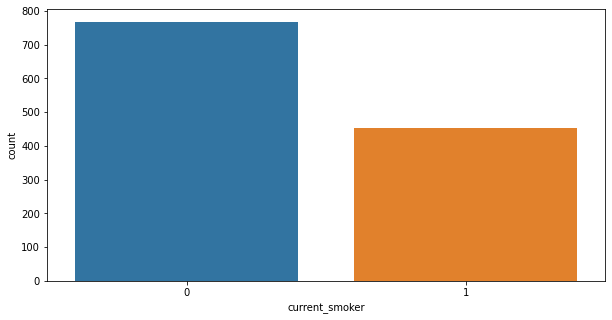

In [70]:
rcParams['figure.figsize'] = 10,5
sns.countplot(x="current_smoker", data=df)

## <span style="color:red">2b. Question</span> (1pt)
1. Is this data balanced or not? Explain.

In [71]:
df['current_smoker'].value_counts()

0    767
1    454
Name: current_smoker, dtype: int64

In [72]:
df['current_smoker'].value_counts(normalize=True)

0    0.628174
1    0.371826
Name: current_smoker, dtype: float64

This data is not balanced. In the countplot, class 1 (=Yes) is a minority class in comparison to class 0 (=No). In code cells [10] and [11], the absolute values and the frequencies of both classes are given. Class 0 accounts for almost 63% of the dataset, class 1 37%

## 3. Dimensionality reduction (4.5pt)
The dataset consists out of a big number of features. Before continuing, let's reduce those.
* Store the "age" and "current_smoker" into two different variables. Remove them from the dataset.
* Remove any non-informative columns (if applicable).
* Scale the data using a standardscaler.
* Perform a PCA on the dataset. Reduce the number of features to 100

In [73]:
age_list = df['age']
current_smoker_list = df['current_smoker']
df.drop('age', axis=1, inplace=True)
df.drop('current_smoker', axis=1, inplace=True)

In [74]:
df.head()

,sample,ENSG00000279928,ENSG00000225972,ENSG00000225630,ENSG00000237973,ENSG00000229344,ENSG00000248527,ENSG00000198744,ENSG00000237491,ENSG00000228794,ENSG00000187961,ENSG00000187583,ENSG00000187608,ENSG00000188157,ENSG00000176022,ENSG00000230415,ENSG00000162572,ENSG00000169972,ENSG00000224051,ENSG00000169962,ENSG00000224870,ENSG00000272455,ENSG00000215915,ENSG00000160072,ENSG00000197785,ENSG00000215014,ENSG00000197530,ENSG00000272004,ENSG00000227775,ENSG00000231050,ENSG00000067606,ENSG00000157933,ENSG00000157916,ENSG00000149527,ENSG00000272449,ENSG00000157873,ENSG00000225931,ENSG00000228037,ENSG00000157870,ENSG00000158109,ENSG00000235169,ENSG00000169598,ENSG00000236423,ENSG00000196581,ENSG00000069424,ENSG00000158286,ENSG00000271746,ENSG00000187017,ENSG00000204859,ENSG00000116273,ENSG00000041988,ENSG00000171735,ENSG00000049245,ENSG00000269925,ENSG00000049246,ENSG00000116288,ENSG00000284747,ENSG00000232912,ENSG00000230679,ENSG00000131686,ENSG00000049239,ENSG00000171621,ENSG00000171612,ENSG00000231181,ENSG00000188807,ENSG00000171608,ENSG00000228150,ENSG00000173614,ENSG00000202415,ENSG00000162444,ENSG00000130939,ENSG00000233623,ENSG00000201746,ENSG00000054523,ENSG00000199562,ENSG00000284642,ENSG00000142657,ENSG00000175279,ENSG00000142655,ENSG00000120948,ENSG00000271895,ENSG00000226849,ENSG00000120942,ENSG00000204624,ENSG00000132879,ENSG00000116663,ENSG00000162490,ENSG00000177674,ENSG00000011021,ENSG00000285646,ENSG00000083444,ENSG00000116688,ENSG00000116691,ENSG00000120949,ENSG00000028137,ENSG00000263676,ENSG00000048707,ENSG00000239149,ENSG00000116731,ENSG00000189337,ENSG00000171729,ENSG00000142621,ENSG00000142634,ENSG00000116138,ENSG00000251866,ENSG00000235084,ENSG00000197312,ENSG00000116786,ENSG00000162461,ENSG00000178715,ENSG00000065526,ENSG00000055070,ENSG00000157191,ENSG00000226029,ENSG00000186301,ENSG00000058453,ENSG00000207005,ENSG00000159339,ENSG00000276747,ENSG00000074964,ENSG00000179023,ENSG00000230424,ENSG00000053372,ENSG00000040487,ENSG00000240490,ENSG00000173436,ENSG00000226396,ENSG00000158747,ENSG00000169914,ENSG00000162543,ENSG00000158825,ENSG00000158828,ENSG00000236936,ENSG00000231105,ENSG00000142794,ENSG00000162551,ENSG00000233431,ENSG00000187942,ENSG00000218510,ENSG00000070831,ENSG00000230068,ENSG00000285721,ENSG00000184677,ENSG00000237200,ENSG00000173372,ENSG00000173369,ENSG00000133216,ENSG00000004487,ENSG00000249087,ENSG00000197880,ENSG00000142676,ENSG00000011007,ENSG00000057757,ENSG00000011009,ENSG00000189266,ENSG00000001461,ENSG00000117602,ENSG00000133226,ENSG00000169504,ENSG00000229162,ENSG00000284602,ENSG00000284657,ENSG00000187010,ENSG00000183726,ENSG00000238084,ENSG00000204178,ENSG00000157978,ENSG00000225643,ENSG00000117643,ENSG00000162430,ENSG00000117640,ENSG00000236528,ENSG00000175087,ENSG00000142684,ENSG00000142675,ENSG00000130695,ENSG00000142669,ENSG00000169442,ENSG00000117682,ENSG00000198830,ENSG00000117676,ENSG00000117713,ENSG00000060642,ENSG00000204160,ENSG00000175793,ENSG00000090273,ENSG00000253368,ENSG00000225159,ENSG00000142784,ENSG00000243659,ENSG00000186501,ENSG00000206888,ENSG00000241547,ENSG00000142765,ENSG00000237429,ENSG00000235912,ENSG00000009780,ENSG00000231344,ENSG00000230833,ENSG00000117758,ENSG00000269971,ENSG00000270031,ENSG00000117751,ENSG00000252947,ENSG00000130775,ENSG00000130768,ENSG00000158156,ENSG00000130770,ENSG00000130766,ENSG00000130772,ENSG00000204138,ENSG00000229820,ENSG00000180198,ENSG00000242125,ENSG00000200087,ENSG00000279443,ENSG00000180098,ENSG00000229388,ENSG00000274978,ENSG00000162419,ENSG00000198492,ENSG00000159023,ENSG00000277958,ENSG00000060656,ENSG00000186056,ENSG00000121766,ENSG00000168528,ENSG00000260386,ENSG00000284543,ENSG00000235790,ENSG00000121774,ENSG00000121775,ENSG00000025800,ENSG00000084652,ENSG00000160050,ENSG00000160051,ENSG00000084623,ENSG00000182866,ENSG00000116478,ENSG00000162526,ENSG00000162521,ENSG00000162522,ENSG00000116497,ENSG00000142920,ENSG00000279179,ENSG00000160094,ENSG00000270115,ENSG00000233246,ENSG00000121903,ENSG00000197056,...,ENSG

Age is now stored in variable *age_list*. Current smoker status is now stored in variable *current_smoker_list*. Dropping these columns from the datafram results in the dataframe as shown above this MarkDown cell.

The columns with the sample ID is a non-informative column. It is a random ID given to a sample and has no link to the results of the sample, nor the patient's characteristics. This columns is dropped below.

In [75]:
df.drop('sample', axis=1, inplace=True)

In [76]:
df.head()

,ENSG00000279928,ENSG00000225972,ENSG00000225630,ENSG00000237973,ENSG00000229344,ENSG00000248527,ENSG00000198744,ENSG00000237491,ENSG00000228794,ENSG00000187961,ENSG00000187583,ENSG00000187608,ENSG00000188157,ENSG00000176022,ENSG00000230415,ENSG00000162572,ENSG00000169972,ENSG00000224051,ENSG00000169962,ENSG00000224870,ENSG00000272455,ENSG00000215915,ENSG00000160072,ENSG00000197785,ENSG00000215014,ENSG00000197530,ENSG00000272004,ENSG00000227775,ENSG00000231050,ENSG00000067606,ENSG00000157933,ENSG00000157916,ENSG00000149527,ENSG00000272449,ENSG00000157873,ENSG00000225931,ENSG00000228037,ENSG00000157870,ENSG00000158109,ENSG00000235169,ENSG00000169598,ENSG00000236423,ENSG00000196581,ENSG00000069424,ENSG00000158286,ENSG00000271746,ENSG00000187017,ENSG00000204859,ENSG00000116273,ENSG00000041988,ENSG00000171735,ENSG00000049245,ENSG00000269925,ENSG00000049246,ENSG00000116288,ENSG00000284747,ENSG00000232912,ENSG00000230679,ENSG00000131686,ENSG00000049239,ENSG00000171621,ENSG00000171612,ENSG00000231181,ENSG00000188807,ENSG00000171608,ENSG00000228150,ENSG00000173614,ENSG00000202415,ENSG00000162444,ENSG00000130939,ENSG00000233623,ENSG00000201746,ENSG00000054523,ENSG00000199562,ENSG00000284642,ENSG00000142657,ENSG00000175279,ENSG00000142655,ENSG00000120948,ENSG00000271895,ENSG00000226849,ENSG00000120942,ENSG00000204624,ENSG00000132879,ENSG00000116663,ENSG00000162490,ENSG00000177674,ENSG00000011021,ENSG00000285646,ENSG00000083444,ENSG00000116688,ENSG00000116691,ENSG00000120949,ENSG00000028137,ENSG00000263676,ENSG00000048707,ENSG00000239149,ENSG00000116731,ENSG00000189337,ENSG00000171729,ENSG00000142621,ENSG00000142634,ENSG00000116138,ENSG00000251866,ENSG00000235084,ENSG00000197312,ENSG00000116786,ENSG00000162461,ENSG00000178715,ENSG00000065526,ENSG00000055070,ENSG00000157191,ENSG00000226029,ENSG00000186301,ENSG00000058453,ENSG00000207005,ENSG00000159339,ENSG00000276747,ENSG00000074964,ENSG00000179023,ENSG00000230424,ENSG00000053372,ENSG00000040487,ENSG00000240490,ENSG00000173436,ENSG00000226396,ENSG00000158747,ENSG00000169914,ENSG00000162543,ENSG00000158825,ENSG00000158828,ENSG00000236936,ENSG00000231105,ENSG00000142794,ENSG00000162551,ENSG00000233431,ENSG00000187942,ENSG00000218510,ENSG00000070831,ENSG00000230068,ENSG00000285721,ENSG00000184677,ENSG00000237200,ENSG00000173372,ENSG00000173369,ENSG00000133216,ENSG00000004487,ENSG00000249087,ENSG00000197880,ENSG00000142676,ENSG00000011007,ENSG00000057757,ENSG00000011009,ENSG00000189266,ENSG00000001461,ENSG00000117602,ENSG00000133226,ENSG00000169504,ENSG00000229162,ENSG00000284602,ENSG00000284657,ENSG00000187010,ENSG00000183726,ENSG00000238084,ENSG00000204178,ENSG00000157978,ENSG00000225643,ENSG00000117643,ENSG00000162430,ENSG00000117640,ENSG00000236528,ENSG00000175087,ENSG00000142684,ENSG00000142675,ENSG00000130695,ENSG00000142669,ENSG00000169442,ENSG00000117682,ENSG00000198830,ENSG00000117676,ENSG00000117713,ENSG00000060642,ENSG00000204160,ENSG00000175793,ENSG00000090273,ENSG00000253368,ENSG00000225159,ENSG00000142784,ENSG00000243659,ENSG00000186501,ENSG00000206888,ENSG00000241547,ENSG00000142765,ENSG00000237429,ENSG00000235912,ENSG00000009780,ENSG00000231344,ENSG00000230833,ENSG00000117758,ENSG00000269971,ENSG00000270031,ENSG00000117751,ENSG00000252947,ENSG00000130775,ENSG00000130768,ENSG00000158156,ENSG00000130770,ENSG00000130766,ENSG00000130772,ENSG00000204138,ENSG00000229820,ENSG00000180198,ENSG00000242125,ENSG00000200087,ENSG00000279443,ENSG00000180098,ENSG00000229388,ENSG00000274978,ENSG00000162419,ENSG00000198492,ENSG00000159023,ENSG00000277958,ENSG00000060656,ENSG00000186056,ENSG00000121766,ENSG00000168528,ENSG00000260386,ENSG00000284543,ENSG00000235790,ENSG00000121774,ENSG00000121775,ENSG00000025800,ENSG00000084652,ENSG00000160050,ENSG00000160051,ENSG00000084623,ENSG00000182866,ENSG00000116478,ENSG00000162526,ENSG00000162521,ENSG00000162522,ENSG00000116497,ENSG00000142920,ENSG00000279179,ENSG00000160094,ENSG00000270115,ENSG00000233246,ENSG00000121903,ENSG00000197056,ENSG00000228348

In [77]:
ss = preprocessing.StandardScaler()
ss.fit(df)
df_scaled = pd.DataFrame(ss.transform(df), columns=df.columns)

In [78]:
df_scaled.head()

,ENSG00000279928,ENSG00000225972,ENSG00000225630,ENSG00000237973,ENSG00000229344,ENSG00000248527,ENSG00000198744,ENSG00000237491,ENSG00000228794,ENSG00000187961,ENSG00000187583,ENSG00000187608,ENSG00000188157,ENSG00000176022,ENSG00000230415,ENSG00000162572,ENSG00000169972,ENSG00000224051,ENSG00000169962,ENSG00000224870,ENSG00000272455,ENSG00000215915,ENSG00000160072,ENSG00000197785,ENSG00000215014,ENSG00000197530,ENSG00000272004,ENSG00000227775,ENSG00000231050,ENSG00000067606,ENSG00000157933,ENSG00000157916,ENSG00000149527,ENSG00000272449,ENSG00000157873,ENSG00000225931,ENSG00000228037,ENSG00000157870,ENSG00000158109,ENSG00000235169,ENSG00000169598,ENSG00000236423,ENSG00000196581,ENSG00000069424,ENSG00000158286,ENSG00000271746,ENSG00000187017,ENSG00000204859,ENSG00000116273,ENSG00000041988,ENSG00000171735,ENSG00000049245,ENSG00000269925,ENSG00000049246,ENSG00000116288,ENSG00000284747,ENSG00000232912,ENSG00000230679,ENSG00000131686,ENSG00000049239,ENSG00000171621,ENSG00000171612,ENSG00000231181,ENSG00000188807,ENSG00000171608,ENSG00000228150,ENSG00000173614,ENSG00000202415,ENSG00000162444,ENSG00000130939,ENSG00000233623,ENSG00000201746,ENSG00000054523,ENSG00000199562,ENSG00000284642,ENSG00000142657,ENSG00000175279,ENSG00000142655,ENSG00000120948,ENSG00000271895,ENSG00000226849,ENSG00000120942,ENSG00000204624,ENSG00000132879,ENSG00000116663,ENSG00000162490,ENSG00000177674,ENSG00000011021,ENSG00000285646,ENSG00000083444,ENSG00000116688,ENSG00000116691,ENSG00000120949,ENSG00000028137,ENSG00000263676,ENSG00000048707,ENSG00000239149,ENSG00000116731,ENSG00000189337,ENSG00000171729,ENSG00000142621,ENSG00000142634,ENSG00000116138,ENSG00000251866,ENSG00000235084,ENSG00000197312,ENSG00000116786,ENSG00000162461,ENSG00000178715,ENSG00000065526,ENSG00000055070,ENSG00000157191,ENSG00000226029,ENSG00000186301,ENSG00000058453,ENSG00000207005,ENSG00000159339,ENSG00000276747,ENSG00000074964,ENSG00000179023,ENSG00000230424,ENSG00000053372,ENSG00000040487,ENSG00000240490,ENSG00000173436,ENSG00000226396,ENSG00000158747,ENSG00000169914,ENSG00000162543,ENSG00000158825,ENSG00000158828,ENSG00000236936,ENSG00000231105,ENSG00000142794,ENSG00000162551,ENSG00000233431,ENSG00000187942,ENSG00000218510,ENSG00000070831,ENSG00000230068,ENSG00000285721,ENSG00000184677,ENSG00000237200,ENSG00000173372,ENSG00000173369,ENSG00000133216,ENSG00000004487,ENSG00000249087,ENSG00000197880,ENSG00000142676,ENSG00000011007,ENSG00000057757,ENSG00000011009,ENSG00000189266,ENSG00000001461,ENSG00000117602,ENSG00000133226,ENSG00000169504,ENSG00000229162,ENSG00000284602,ENSG00000284657,ENSG00000187010,ENSG00000183726,ENSG00000238084,ENSG00000204178,ENSG00000157978,ENSG00000225643,ENSG00000117643,ENSG00000162430,ENSG00000117640,ENSG00000236528,ENSG00000175087,ENSG00000142684,ENSG00000142675,ENSG00000130695,ENSG00000142669,ENSG00000169442,ENSG00000117682,ENSG00000198830,ENSG00000117676,ENSG00000117713,ENSG00000060642,ENSG00000204160,ENSG00000175793,ENSG00000090273,ENSG00000253368,ENSG00000225159,ENSG00000142784,ENSG00000243659,ENSG00000186501,ENSG00000206888,ENSG00000241547,ENSG00000142765,ENSG00000237429,ENSG00000235912,ENSG00000009780,ENSG00000231344,ENSG00000230833,ENSG00000117758,ENSG00000269971,ENSG00000270031,ENSG00000117751,ENSG00000252947,ENSG00000130775,ENSG00000130768,ENSG00000158156,ENSG00000130770,ENSG00000130766,ENSG00000130772,ENSG00000204138,ENSG00000229820,ENSG00000180198,ENSG00000242125,ENSG00000200087,ENSG00000279443,ENSG00000180098,ENSG00000229388,ENSG00000274978,ENSG00000162419,ENSG00000198492,ENSG00000159023,ENSG00000277958,ENSG00000060656,ENSG00000186056,ENSG00000121766,ENSG00000168528,ENSG00000260386,ENSG00000284543,ENSG00000235790,ENSG00000121774,ENSG00000121775,ENSG00000025800,ENSG00000084652,ENSG00000160050,ENSG00000160051,ENSG00000084623,ENSG00000182866,ENSG00000116478,ENSG00000162526,ENSG00000162521,ENSG00000162522,ENSG00000116497,ENSG00000142920,ENSG00000279179,ENSG00000160094,ENSG00000270115,ENSG00000233246,ENSG00000121903,ENSG00000197056,ENSG00000228348

The data is now scaled with the standardscaler. The resulting head of the dataframe is shown in the cell above.

In [79]:
pca_model = PCA(n_components=100)
df_pca = pca_model.fit_transform(df_scaled)

In [80]:
df_pca.shape

(1221, 100)

After dimensionality reduction with Principal Component Analysis, the number of features are succesfully reduced to 100 as shown with the shape-method

## 4a. Linear regression (5.5pt)
Now try and predict the **age** based on your PCA features.
* Create a training and test set. Keep approximately 30% of the data as the test set
* Create a linear regression model with L2 regularisation. Play around with the regularisation parameter so you have a model that performs okay on both training and test set. **Note:** you don't need to optimize the model! The model will never perform that well (score +-30-50%)!
    * Print the score of both the training and test set
    * Print the mean absolute error and the mean squared error you get on the train and test set.

In [81]:
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(df_pca, age_list, test_size=0.30, random_state=0)

In [82]:
reg = linear_model.Ridge(tol=0.0001,fit_intercept=True) 
grid_reg = {'alpha': np.logspace(-2,3,100)}
reg_gs = GridSearchCV(reg, grid_reg, cv=8, n_jobs=-1, scoring='r2', verbose=1)
reg_gs.fit(X_train_reg,y_train_reg)
print(f"Best parameters:\t{reg_gs.best_params_}")
print(f"Best score: \t{reg_gs.best_score_}")

Fitting 8 folds for each of 100 candidates, totalling 800 fits
Best parameters:	{'alpha': 1000.0}
Best score: 	0.13810338901064712


In [83]:
y_pred_reg = reg_gs.predict(X_test_reg)
y_train_pred = reg_gs.predict(X_train_reg)

r2train = reg_gs.score(X_train_reg, y_train_reg)
r2test = reg_gs.score(X_test_reg, y_test_reg)

maetrain = mean_absolute_error(y_train_reg, y_train_pred)
maetest = mean_absolute_error(y_test_reg, y_pred_reg)

msetrain = mean_squared_error(y_train_reg, y_train_pred)
msetest = mean_squared_error(y_test_reg, y_pred_reg)

print(f"For the best model, the R² score for training set is: \t{r2train}")
print(f"For the best model, the R² score for test set is: \t{r2test}\n")
print(f"For the best model, the MAE for training set is: \t{maetrain}")
print(f"For the best model, the MAE for test set is: \t\t{maetest}\n")
print(f"For the best model, the MSE for training set is: \t{msetrain}")
print(f"For the best model, the MSE for test set is: \t\t{msetest}")

For the best model, the R² score for training set is: 	0.5485883184613305
For the best model, the R² score for test set is: 	0.2171682570460527

For the best model, the MAE for training set is: 	4.691727810979587
For the best model, the MAE for test set is: 		6.044323810409122

For the best model, the MSE for training set is: 	34.680243614991035
For the best model, the MSE for test set is: 		64.94578761233404


## <span style="color:red">4b. Questions</span> (2pt)
1. **What does the score from a Linear Regression Model represent? What would it mean if the model had a score of 0?**

The R² score represents the ratio of Mean Squared Errors to Mean Absolute Errors, substracted from 1. If the score would be 1 the model would predict perfectly. If the score is negative, giving the mean value of the target as prediction would perform better than the predictions of the model itself. 

At a score of 0, the model performs even good (or worse) as giving the mean value of the target.
    

2. **Is the model under- and/or overfitting? Explain.** 

This model is underfitting. It is bad at predicting the values of both the training set and the test set. This is represented by the R² score for each set.


## 5. Logistic regression (4.5pt)
Next perform logistic regression, for this try to predict if the sample is from a person that is currently smoking.
* Make a new train and test set. The features will still be our PCA features. The target will be current_smoker. Again keep 30% as test set.
* Perform a **grid search** where you vary the C-values and the regularisation used.
    * Perform a 5-fold cross validation
    * Test 20 C-values between 0.0001 and 1
    * Test both L1 and L2 regularisation
* What are the best parameters for the model?
* Print the score for both the training and the test set
* Print the precision, recall and F1-score for the test set

In [84]:
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(df_pca, current_smoker_list, test_size=0.30, random_state=0)

In [85]:
clf = linear_model.LogisticRegression(max_iter=10000) # max_iter set for avoiding convergence warnings

grid_clf=[
    {'solver': ['lbfgs'], 'C': np.logspace(-4, 0, 20), 'penalty': ['l2'], "class_weight": ["balanced"]},
    {'solver': ['liblinear'], 'C': np.logspace(-4, 0, 20), 'penalty': ['l2', 'l1'], "class_weight": ["balanced"]}
]

# Logistic regression
clf_gs = GridSearchCV(clf, grid_clf, cv=5, n_jobs=-1, scoring='accuracy', verbose=1)

clf_gs.fit(X_train_clf, y_train_clf)

# Best parameters and score
print(f"Best parameters:\t{clf_gs.best_params_}")
print(f"Best score: \t{clf_gs.best_score_}")

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Best parameters:	{'C': 0.012742749857031334, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'lbfgs'}
Best score: 	0.8442518059855519


The best logistic regression model has following parameters:
- Solver: lbfgs
- C: 0.012742749857031334
- Penalty: L2 (regularization)

In this grid search, 2 more parameters were added:
- Solver: the default solver (lbfgs) is only allowed 'L2' as regularization. As I needed to test for L1 as well, I added liblinear as another solver.
- Class weight: as the data is unbalanced, I added a balanced class weight for all models.

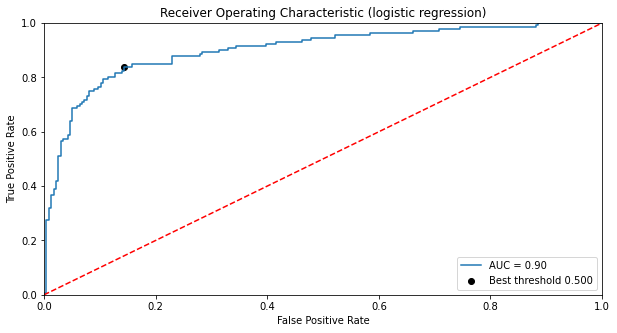

In [86]:
# ROC and AUC (I always like to draw them when classifying
# And I use it to compare it with the Random Forest Classifier below)
clf_probs = clf_gs.predict_proba(X_test_clf)
clf_preds = clf_probs[:,1]
clf_fpr, clf_tpr, clf_threshold = roc_curve(y_test_clf, clf_preds)
clf_roc_auc = auc(clf_fpr, clf_tpr)
clf_gmeans = np.sqrt(clf_tpr * (1-clf_fpr))
clf_ix = np.argmax(clf_gmeans)

plt.title(f'Receiver Operating Characteristic (logistic regression)')
plt.plot(clf_fpr, clf_tpr, label = f'AUC = {clf_roc_auc:.2f}')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.scatter(clf_fpr[clf_ix], clf_tpr[clf_ix], marker='o', color='black', label=f'Best threshold {clf_threshold[clf_ix]:.3f}')
plt.legend(loc = 'lower right')
plt.show()

Confusion matrix and classification report for the test set:


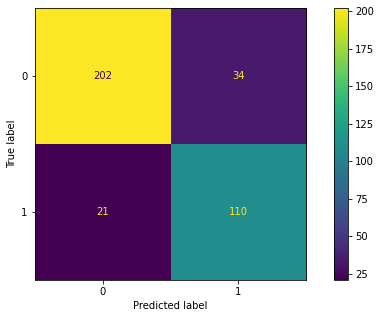

              precision    recall  f1-score   support

           0       0.91      0.86      0.88       236
           1       0.76      0.84      0.80       131

    accuracy                           0.85       367
   macro avg       0.83      0.85      0.84       367
weighted avg       0.86      0.85      0.85       367



In [87]:
print("Confusion matrix and classification report for the test set:")
clf_test_pred = (clf_gs.predict(X_test_clf))
ConfusionMatrixDisplay.from_predictions(y_test_clf, clf_test_pred)  
plt.show()

# Classification report
print(classification_report(y_test_clf,clf_test_pred))

Confusion matrix and classification report for the training set:


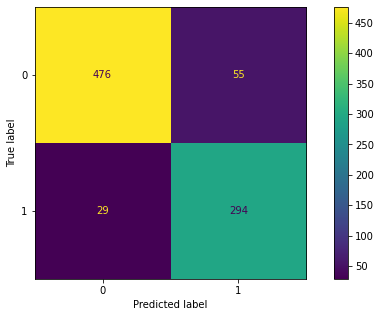

              precision    recall  f1-score   support

           0       0.94      0.90      0.92       531
           1       0.84      0.91      0.88       323

    accuracy                           0.90       854
   macro avg       0.89      0.90      0.90       854
weighted avg       0.90      0.90      0.90       854



In [88]:
print("Confusion matrix and classification report for the training set:")
clf_train_pred = (clf_gs.predict(X_train_clf))

ConfusionMatrixDisplay.from_predictions(y_train_clf, clf_train_pred)  
plt.show()

# Classification report
print(classification_report(y_train_clf,clf_train_pred))

In [89]:
# Print accuracy in accordance with question 
acc_test = accuracy_score(y_test_clf,clf_test_pred)
acc_train = accuracy_score(y_train_clf,clf_train_pred)
print(f"The accuracy score on the test set is:\t\t{acc_test:.3F}")
print(f"The accuracy score on the training set is:\t{acc_train:.3F}")

The accuracy score on the test set is:		0.850
The accuracy score on the training set is:	0.902


In [90]:
# Print precision, recall and F1 for the test set
precision_test = precision_score(y_test_clf,clf_test_pred)
recall_test = recall_score(y_test_clf,clf_test_pred)
f1_test = f1_score(y_test_clf,clf_test_pred)
print(f"The precision on the test set is:\t{precision_test:.3F}")
print(f"The recall on the test set is:\t\t{recall_test:.3F}")
print(f"The F1-score on the test set is:\t{f1_test:.3F}")

The precision on the test set is:	0.764
The recall on the test set is:		0.840
The F1-score on the test set is:	0.800


## 6a. Decision trees (2.5pt)
Finally let's also create a random forest tree model.
* Use the same train and test set as you used for logistic regression.
* Create a random forest model that will classify the samples as smoker or not smoker.
    * Allow bootstrapping
    * Let each tree use 10% of the training samples
    * Allow up to three splits per tree
    * Use 20 decision trees
    * Use a balanced class weight
* Print the confusion matrix
* Show the ROC curve. What is the AUROC of your model?


Confusion matrix for the Random Forest Classifier


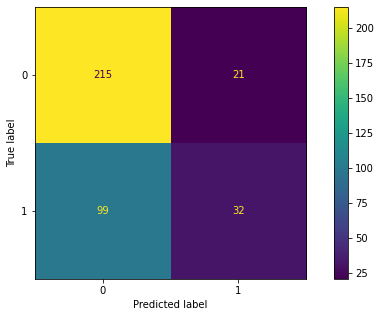

              precision    recall  f1-score   support

           0       0.68      0.91      0.78       236
           1       0.60      0.24      0.35       131

    accuracy                           0.67       367
   macro avg       0.64      0.58      0.56       367
weighted avg       0.66      0.67      0.63       367



In [91]:
rfc = RandomForestClassifier(n_estimators=20, 
                             bootstrap=True, 
                             max_depth=3,
                             max_samples=0.1,
                             class_weight='balanced')

rfc.fit(X_train_clf, y_train_clf)

print("Confusion matrix for the Random Forest Classifier")
rfc_test_pred = (rfc.predict(X_test_clf))
ConfusionMatrixDisplay.from_predictions(y_test_clf, rfc_test_pred)  
plt.show()

print(classification_report(y_test_clf,rfc_test_pred))

ROC curve for the Random Forest Classifier


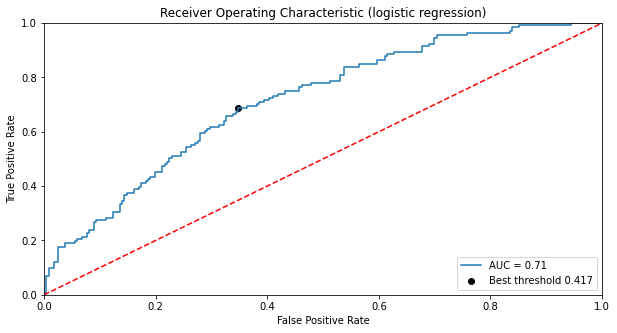

In [92]:
print("ROC curve for the Random Forest Classifier")
rfc_probs = rfc.predict_proba(X_test_clf)
rfc_preds = rfc_probs[:,1]
rfc_fpr, rfc_tpr, rfc_threshold = roc_curve(y_test_clf, rfc_preds)
rfc_roc_auc = auc(rfc_fpr, rfc_tpr)
rfc_gmeans = np.sqrt(rfc_tpr * (1-rfc_fpr))
rfc_ix = np.argmax(rfc_gmeans)

plt.title(f'Receiver Operating Characteristic (logistic regression)')
plt.plot(rfc_fpr, rfc_tpr, label = f'AUC = {rfc_roc_auc:.2f}')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.scatter(rfc_fpr[rfc_ix], rfc_tpr[rfc_ix], marker='o', color='black', label=f'Best threshold {rfc_threshold[rfc_ix]:.3f}')
plt.legend(loc = 'lower right')
plt.show()

### <span style="color:red">6b. Questions</span> (2pt)
1. **Is this a better or a worse model than your logistic regression model? Explain.**

The Random Forest Tree classifier is a **worse** model than logistic regression. The accuracy is a lot worse (67% against 85%) on the test set. 

Furthermore, the AUC for the ROC curve is much lower for the Random Forest Tree Classifierd (0.71 against 0.90). 

Looking at these ROC curves, you can see that for the logistic regression model, the most optimal threshold still tries to reach for ROC heaven. This is not clearly seen in the ROC curve of the Random Forest Tree classifier. The ROC curve of the Random Forest Tree classifier tends to flatten to the red dotted line


2. **How do you need to interpret the ROC curve (What is a good AUROC value, what is a bad AUROC model)? Also discuss what is on the X- and Y-axis and how we should interpret these values.**

The ROC curve plots the True Positive Rate (TPR) on the Y-axis in function of the False Positive Rate (FPR) on the X-axis. As the threshold is shifted from 0 to 1 each value of TPR and FPR for each threshold is plotted, resulting in the ROC curve.

The best models and the best thresholds are the ones with the least FPR and the best TPR. These are the values for a threshold, that can be found in the upperleft corner of the plot. If this value is [0,1] than we are in ROC-heaven leading to a perfect prediction model. 

The area under the curve (AUC) is the area between the X-axis and the plot line. If ROC-heaven is reached, this value is 1. The higher the value of AUC, the better the model. The lower the value of AUC, the worse the model. Generally, I tend to have a model with an AUC of at least 0.95. 

ROC hell is at the other site of the graph (lower right corner). At this point, the model predicts everyting wrong. This would be the worst value (AUC = 0)


